
__Name:Sanjit Verma
Github UserID:sanjithverma__


In [1]:
import csv
import os, re
import glob
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegressionCV


__Reading the data from the dataset. From the time-domain features that are usually used in time series classifcation, we have used minimum, maximum, mean, median, standard deviation, first quartile and third quartile. Obtaining these time-domain features from all the 88 instances present in our domain.__

In [2]:
root_dir = "../Data/AReM/"
#Creating relevant from the filenames
def createDataSets(filename,start,stop):
    data = []
    for i in range(start,stop,1):
        path = root_dir+filename+"/dataset"+str(i)+".csv"
        sniffer = csv.Sniffer()
        sept = sniffer.sniff(open(path).read()).delimiter
        if sept == ",":
            df = pd.read_csv(path, skiprows=5, header=None, error_bad_lines=False, warn_bad_lines=False,index_col=None)
        else:
            df = pd.read_csv(path, skiprows=5, header=None, sep="\s+", error_bad_lines=False, warn_bad_lines=False,index_col=None)
        df.columns = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
        df['Foldername'] = filename
        df['Filename'] = "dataset"+str(i)
        data.append(df)

    dataFrame = pd.concat(data, axis=0, ignore_index=True)
    return dataFrame


In [3]:
test_1 = createDataSets('bending1',1,3)
train_1 = createDataSets('bending1',3,8)

test_2 = createDataSets('bending2',1,3)
train_2 = createDataSets('bending2',3,7)

test_3 = createDataSets('cycling',1,4)
train_3 = createDataSets('cycling',4,16)

test_4 = createDataSets('lying',1,4)
train_4 = createDataSets('lying',4,16)

test_5 = createDataSets('sitting',1,4)
train_5 = createDataSets('sitting',4,16)

test_6 = createDataSets('standing',1,4)
train_6 = createDataSets('standing',4,16)

test_7 = createDataSets('walking',1,4)
train_7 = createDataSets('walking',4,16)

test_set = pd.concat([test_1,test_2,test_3,test_4,test_5,test_6,test_7])
train_set = pd.concat([train_1,train_2,train_3,train_4,train_5,train_6,train_7])


In [4]:
test_set

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Foldername,Filename
0,0,39.25,0.43,22.75,0.43,33.75,1.30,bending1,dataset1
1,250,39.25,0.43,23.00,0.00,33.00,0.00,bending1,dataset1
2,500,39.25,0.43,23.25,0.43,33.00,0.00,bending1,dataset1
3,750,39.50,0.50,23.00,0.71,33.00,0.00,bending1,dataset1
4,1000,39.50,0.50,24.00,0.00,33.00,0.00,bending1,dataset1
...,...,...,...,...,...,...,...,...,...
1435,118750,36.00,2.45,17.00,5.10,20.50,0.87,walking,dataset3
1436,119000,34.33,1.89,15.00,2.45,17.00,2.12,walking,dataset3
1437,119250,33.00,7.35,14.60,3.14,13.00,5.70,walking,dataset3
1438,119500,31.67,1.25,11.00,6.16,19.25,2.17,walking,dataset3


In [5]:
train_set

,time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,Foldername,Filename
0,0,42.00,0.71,21.25,0.43,30.00,0.00,bending1,dataset3
1,250,41.50,0.50,20.25,1.48,31.25,1.09,bending1,dataset3
2,500,41.50,0.50,14.25,1.92,33.00,0.00,bending1,dataset3
3,750,40.75,0.83,15.75,0.43,33.00,0.00,bending1,dataset3
4,1000,40.00,0.71,20.00,2.74,32.75,0.43,bending1,dataset3
...,...,...,...,...,...,...,...,...,...
5755,118750,34.50,6.18,9.00,3.56,12.67,4.19,walking,dataset15
5756,119000,25.75,6.02,13.75,2.05,16.00,1.58,walking,dataset15
5757,119250,31.50,3.35,10.25,5.12,16.25,2.95,walking,dataset15
5758,119500,33.75,2.77,14.00,3.24,13.75,0.43,walking,dataset15


__I am delving into the feature extraction phase, focusing on time-domain features for time series classification.__

I've conducted research to identify the most relevant time-domain features typically used in this field. The features we plan to extract and analyze include:

Basic Statistical Measures: Mean, Median, Maximum, Minimum
Dispersion Metrics: Standard Deviation, Variance
Quartiles: First and Third Quartiles
Shape Attributes: Skewness, Kurtosis, Higher Order Moments
Others: Mean Absolute Deviation, Root Mean Square, Waveform Length, Zero Crossing
Each of these features will be extracted from our time series data to build a robust classification model.

In [6]:
#Calculating time-domain features for all 6 time series
cd = os.path.dirname(os.path.abspath(root_dir))
columns = range(1,100)
all_features_list = []
for root, dirs, files in os.walk(cd):
    n = len(files)
    for x in range(1,n+1):
        rootname=root.split()[-1].split('\\')[-1]
        fname = "dataset"+str(x)+".csv"
        path = os.path.join(root, fname)
        sniffer = csv.Sniffer()
        sep = sniffer.sniff(open(path).read()).delimiter
        if sep == ",":
            df = pd.read_csv(path, skiprows=5, header=None, error_bad_lines=False, warn_bad_lines=False,index_col=None)
        else:
            df = pd.read_csv(path, skiprows=5, header=None, sep="\s+", error_bad_lines=False, warn_bad_lines=False,index_col=None)
        df.columns = ['time','avg_rss12','var_rss12','avg_rss13','var_rss13','avg_rss23','var_rss23']
        all_features = []
        for i in df.columns:
            if i == 'time':
                continue
            all_features.append(df[i].min())
            all_features.append(df[i].max())
            all_features.append(df[i].mean())
            all_features.append(df[i].median())
            all_features.append(df[i].std())
            all_features.append(np.percentile(df[i],25))
            all_features.append(np.percentile(df[i],75))
        all_features = pd.DataFrame(all_features).T
        all_features['Foldername']=rootname
        all_features['Filename']=fname
        all_features_list.append(all_features)

all_features_list = pd.concat(all_features_list,ignore_index=True)
all_features_list

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,Foldername,Filename
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000,bending1,dataset1.csv
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372438,...,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000,bending1,dataset2.csv
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,bending1,dataset3.csv
3,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,bending1,dataset4.csv
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,bending1,dataset5.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,walking,dataset11.csv
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,17.75,0.00,9.67,3.432562,3.20,1.732727,2.1575,4.5650,walking,dataset12.csv
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,walking,dataset13.csv
86,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,walking,dataset14.csv


In [7]:
#Addition of column names for the 6 series
columns = []
column_names = ['Min','Max','Mean','Median','Std','Q1','Q3']
for i in range(1,7):
    for j in column_names:
        columns.append(j+"_"+str(i))
columns.append('Foldername')
columns.append('Filename')
all_features_list.columns = columns

In [8]:
all_time_domain_features_list = all_features_list.drop(all_features_list.columns[[-1,-2]], axis = 1)
all_time_domain_features_list

,Min_1,Max_1,Mean_1,Median_1,Std_1,Q1_1,Q3_1,Min_2,Max_2,Mean_2,...,Std_5,Q1_5,Q3_5,Min_6,Max_6,Mean_6,Median_6,Std_6,Q1_6,Q3_6
0,37.25,45.00,40.624792,40.50,1.476967,39.25,42.0000,0.0,1.30,0.358604,...,2.188449,33.0000,36.00,0.00,1.92,0.570583,0.43,0.582915,0.0000,1.3000
1,38.00,45.67,42.812812,42.50,1.435550,42.00,43.6700,0.0,1.22,0.372438,...,1.995255,32.0000,34.50,0.00,3.11,0.571083,0.43,0.601010,0.0000,1.3000
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,1.999604,35.3625,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400
3,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,3.849448,30.4575,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,2.411026,28.4575,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,3.283983,13.7300,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,3.119856,13.5000,17.75,0.00,9.67,3.432562,3.20,1.732727,2.1575,4.5650
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,2.823124,14.0000,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350
86,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,3.131076,13.7500,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000


__This phase involves estimating the standard deviation for each of the time-domain features extracted from our dataset. Understanding the variability of these features is essential for our subsequent analysis and modeling.__

In [9]:
#Standard deviation of each of the tijme-domain features
all_time_domain_features_list.std()

Min_1       9.569975
Max_1       4.394362
Mean_1      5.335718
Median_1    5.440054
Std_1       1.772153
Q1_1        6.153590
Q3_1        5.138925
Min_2       0.000000
Max_2       5.062729
Mean_2      1.574164
Median_2    1.412244
Std_2       0.884105
Q1_2        0.946386
Q3_2        2.125266
Min_3       2.956462
Max_3       4.875137
Mean_3      4.008380
Median_3    4.036396
Std_3       0.946710
Q1_3        4.220658
Q3_3        4.171628
Min_4       0.000000
Max_4       2.183625
Mean_4      1.166114
Median_4    1.145586
Std_4       0.458242
Q1_4        0.843620
Q3_4        1.552504
Min_5       6.124001
Max_5       5.741238
Mean_5      5.675593
Median_5    5.813782
Std_5       1.024898
Q1_5        6.096465
Q3_5        5.531720
Min_6       0.045838
Max_6       2.518921
Mean_6      1.154812
Median_6    1.086474
Std_6       0.517617
Q1_6        0.758584
Q3_6        1.523599
dtype: float64

In [10]:
#90% bootstrap confidence interval
confidence_interval=pd.DataFrame()
for column in all_time_domain_features_list.columns:
    bootstrap_sample_size = len(all_time_domain_features_list[column])
    std_dev = []
    for i in range(1000):
        bootstrap_sample = all_time_domain_features_list[column].sample(n = bootstrap_sample_size, replace = True)
        std_dev.append(bootstrap_sample.std())
    std_dev.sort()
    left = np.percentile(std_dev, (0.1/2)*100)
    right = np.percentile(std_dev, 100-(0.1/2)*100)
    confidence_interval[column] = [left,right]
    
confidence_interval = confidence_interval.T
confidence_interval.columns = ['Left','Right']
confidence_interval

,Left,Right
Min_1,8.262405,10.730539
Max_1,3.341590,5.296487
Mean_1,4.686562,5.863968
Median_1,4.804797,5.980600
Std_1,1.570679,1.957719
Q1_1,5.592756,6.645743
Q3_1,4.379702,5.882691
Min_2,0.000000,0.000000
Max_2,4.613646,5.407417
Mean_2,1.389379,1.710286


__I am addressing a binary classification problem where the primary objective is to distinguish between 'bending' and other activities using our training dataset. This is a part of our broader investigation into activity recognition through sensor data.__

To achieve this, I am focusing on visualizing the relationships between key features identified in the earlier stage of our analysis (as outlined above). The approach involves creating scatter plots that depict these features, which were extracted from time series 1, 2, and 6 of each instance in the dataset.

Approach Details:
Feature Visualization:

The scatter plots will display the specified features from the mentioned time series.
Each plot will represent data points from these time series, providing a visual comparison between the different activities.
Color Coding for Classification:

A crucial aspect of these plots is the use of color to differentiate between 'bending' and other activities. This visual distinction is key to understanding how these activities are separated in the feature space.
The color coding will help in identifying any patterns or clusters that emerge, which are indicative of the inherent differences between the activities.
Analysis Objectives:

The primary aim is to explore how well the features can distinguish between bending and other types of activities.
The scatter plots will serve as a preliminary analysis tool, giving insights into the potential effectiveness of these features for the classification task.

In [12]:
#Train data
file_option = ['dataset1.csv','dataset2.csv']
folder_option = ['walking','sitting','cycling','lying','standing']
all_features_list_train = all_features_list.loc[~all_features_list['Filename'].isin(file_option)]
all_features_list_train = all_features_list_train.loc[~(all_features_list['Foldername'].isin(folder_option) &
                                               all_features_list['Filename'].isin(['dataset3.csv']))]   
all_features_list_train.loc[all_features_list_train['Foldername'].isin(folder_option),'Label'] = '0'
all_features_list_train.loc[~all_features_list_train['Foldername'].isin(folder_option),'Label'] = '1'
all_features_list_train = all_features_list_train.drop(['Foldername','Filename'],axis=1)

In [13]:
all_features_list_train

,Min_1,Max_1,Mean_1,Median_1,Std_1,Q1_1,Q3_1,Min_2,Max_2,Mean_2,...,Q1_5,Q3_5,Min_6,Max_6,Mean_6,Median_6,Std_6,Q1_6,Q3_6,Label
2,35.00,47.40,43.954500,44.33,1.558835,43.00,45.0000,0.0,1.70,0.426250,...,35.3625,36.50,0.00,1.79,0.493292,0.43,0.513506,0.0000,0.9400,1
3,33.00,47.75,42.179813,43.50,3.670666,39.15,45.0000,0.0,3.00,0.696042,...,30.4575,36.33,0.00,2.18,0.613521,0.50,0.524317,0.0000,1.0000,1
4,33.00,45.75,41.678063,41.75,2.243490,41.33,42.7500,0.0,2.83,0.535979,...,28.4575,31.25,0.00,1.79,0.383292,0.43,0.389164,0.0000,0.5000,1
5,37.00,48.00,43.454958,43.25,1.386098,42.50,45.0000,0.0,1.58,0.378083,...,22.2500,24.00,0.00,5.26,0.679646,0.50,0.622534,0.4300,0.8700,1
6,36.25,48.00,43.969125,44.50,1.618364,43.31,44.6700,0.0,1.50,0.413125,...,20.5000,23.75,0.00,2.96,0.555313,0.49,0.487826,0.0000,0.8300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,19.50,45.33,33.586875,34.25,4.650935,30.25,37.0000,0.0,14.67,4.576562,...,13.7300,18.25,0.00,8.32,3.259729,3.11,1.640243,2.0500,4.3225,0
84,19.75,45.50,34.322750,35.25,4.752477,31.00,38.0000,0.0,13.47,4.456333,...,13.5000,17.75,0.00,9.67,3.432562,3.20,1.732727,2.1575,4.5650,0
85,19.50,46.00,34.546229,35.25,4.842294,31.25,37.8125,0.0,12.47,4.371958,...,14.0000,17.75,0.00,10.00,3.338125,3.08,1.656742,2.1600,4.3350,0
86,23.50,46.25,34.873229,35.25,4.531720,31.75,38.2500,0.0,14.82,4.380583,...,13.7500,18.00,0.00,9.51,3.424646,3.27,1.690960,2.1700,4.5000,0


Text(0.5, 1.008, 'Scatterplots of the features selected')

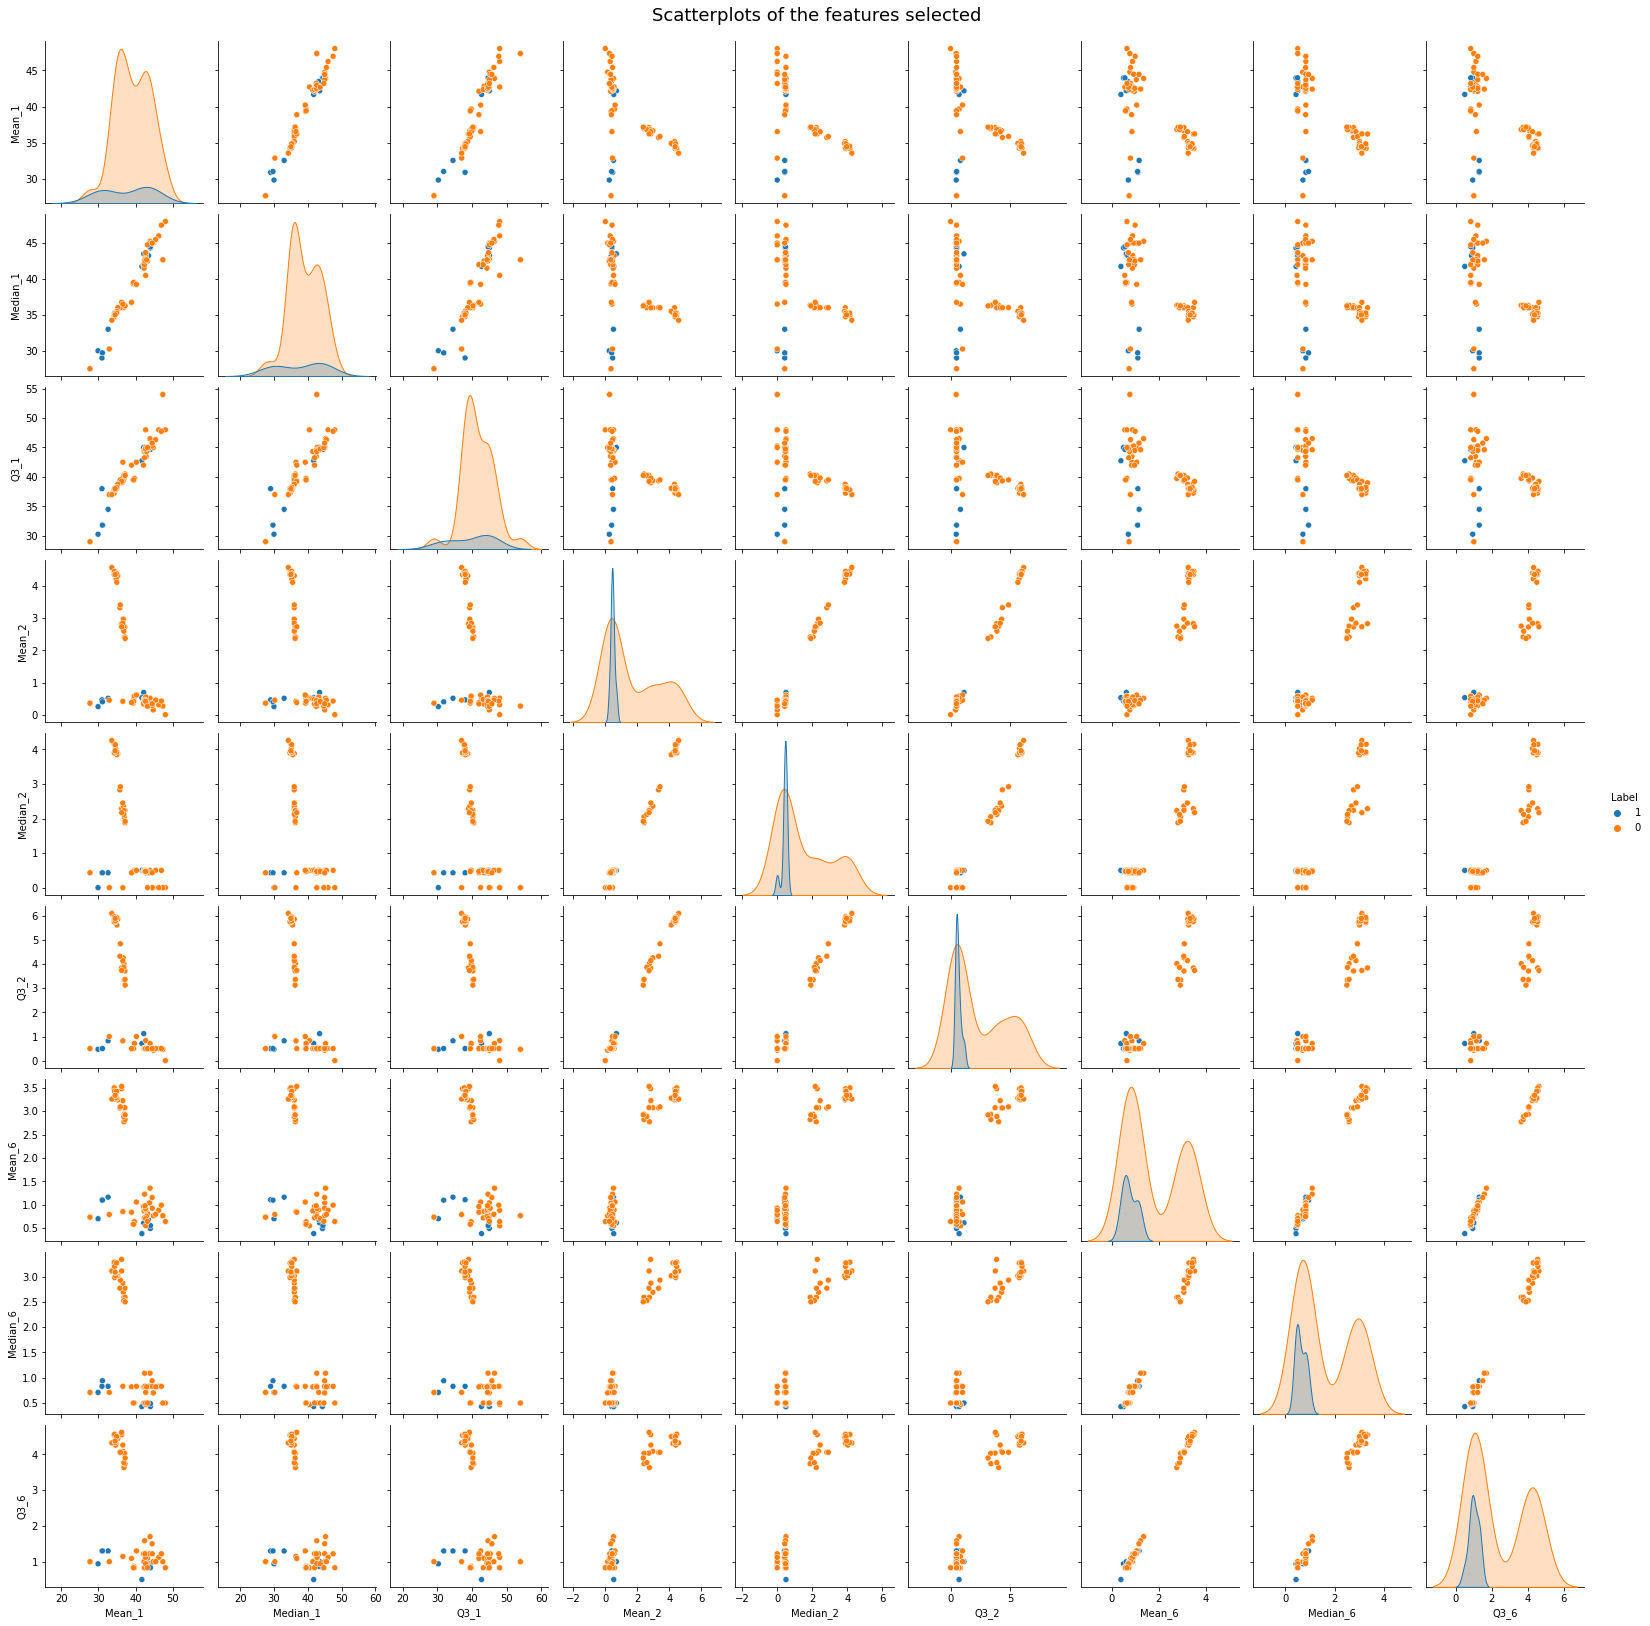

In [14]:
#Scatter plot 
plot = sns.pairplot(all_features_list_train[['Mean_1','Median_1','Q3_1','Mean_2','Median_2','Q3_2','Mean_6','Median_6','Q3_6','Label']],hue='Label')
plot.fig.suptitle("Scatterplots of the features selected", y=1.008, fontsize = 18)

__I'm exploring the impact of segmenting each time series in our training set into two halves, resulting in 12 segments per instance instead of the original 6. This approach aims to assess how dividing the time series affects feature extraction and classification.__

__I'll be depicting scatter plots for the first, second, and twelfth segments of each instance, comparing these with previous results to discern any notable differences in feature distribution due to segmentation. This experiment will help determine the efficacy of time series segmentation in time-domain feature-based classification.__

In [15]:
#Split dataframes function
def splitdata(foldername, start, end, l, is_test, multiclass):
    if is_test == 1:
        tmp = test_set.loc[test_set['Foldername'] == foldername]
    else:
        tmp = train_set.loc[train_set['Foldername'] == foldername]
    dlist = []
    for i in range(start,end):
        datasetname = "dataset"+str(i)
        df = tmp.loc[tmp['Filename']==datasetname]
        df = df.drop(['time','Filename','Foldername'],axis=1)
        #dfchunked = pd.DataFrame(df_frame)
        split = int(len(df)/l)
        data=[]
        for j in range(l):
            splitdf = df[(split*j):(j+1)*split]
            splitdf.reset_index(drop=True, inplace=True)
            data.append(splitdf)
        split_df=pd.concat(data,axis=1,ignore_index=True)
        tmp_features = []
        for i in split_df.columns:
            if i == 'time':
                continue
            tmp_features.append(split_df[i].mean())
            tmp_features.append(split_df[i].median())
            tmp_features.append(np.percentile(split_df[i],75))
        tmp_features = pd.DataFrame(tmp_features).T
        dlist.append(tmp_features)
    df_td_features_splitted = pd.concat(dlist,ignore_index=True)
    columns = []
    column_names = ['Mean','Median','Q3']
    for i in range(1,(l)*6+1):
        for j in column_names:
            columns.append(j+"_"+str(i))
    df_td_features_splitted.columns = columns
    lumns = columns
    if multiclass:
        df_td_features_splitted['Label'] = 'bending' if foldername == "bending1" or foldername == "bending2" else foldername
    else:
        df_td_features_splitted['Label'] = 1 if foldername == "bending1" or foldername == "bending2" else 0
    return df_td_features_splitted



In [62]:
#Calling function for test split dataset
def splitontest(l,multiclass):
    test_split1 = splitdata('bending1',1,3,l,1,multiclass)
    test_split2 = splitdata('bending2',1,3,l,1,multiclass)
    test_split3 = splitdata('cycling',1,4,l,1,multiclass)
    test_split4 = splitdata('lying',1,4,l,1,multiclass)
    test_split5 = splitdata('sitting',1,4,l,1,multiclass)
    test_split6 = splitdata('standing',1,4,l,1,multiclass)
    test_split7 = splitdata('walking',1,4,l,1,multiclass)
    test_data_split = pd.concat([test_split1,test_split2,test_split3,test_split4,test_split5,test_split6,test_split7],ignore_index=True)
    return test_data_split

In [61]:
#Calling function for train split dataset
def splitontrain(l,multiclass):
    train_split1 = splitdata('bending1',3,8,l,0,multiclass)
    train_split2 = splitdata('bending2',3,7,l,0,multiclass)
    train_split3 = splitdata('cycling',4,16,l,0,multiclass)
    train_split4 = splitdata('lying',4,16,l,0,multiclass)
    train_split5 = splitdata('sitting',4,16,l,0,multiclass)
    train_split6 = splitdata('standing',4,16,l,0,multiclass)
    train_split7 = splitdata('walking',4,16,l,0,multiclass)
    train_data_split = pd.concat([train_split1,train_split2,train_split3,train_split4,train_split5,train_split6,train_split7],ignore_index=True)
    return train_data_split

In [63]:
#Break each time series in your training set into two (approximately) equal length time series
train_split_into_2 = splitontrain(2,0)
train_split_into_2

,Mean_1,Median_1,Q3_1,Mean_2,Median_2,Q3_2,Mean_3,Median_3,Q3_3,Mean_4,...,Mean_10,Median_10,Q3_10,Mean_11,Median_11,Q3_11,Mean_12,Median_12,Q3_12,Label
0,44.057167,44.500,45.0000,0.381042,0.470,0.5000,23.096792,24.000,24.0000,0.493458,...,0.501167,0.43,0.7100,34.883375,36.000,36.2500,0.388333,0.000,0.7100,1
1,43.278875,45.000,45.2500,0.673292,0.485,1.0000,23.141250,23.750,24.8125,0.808042,...,1.171792,0.87,1.4800,30.965708,30.415,33.7500,0.586083,0.470,0.8700,1
2,41.621208,42.330,44.2500,0.623083,0.500,0.8300,19.081458,19.500,24.0000,1.115083,...,0.568667,0.47,0.8300,29.635833,29.750,30.5625,0.347500,0.430,0.5000,1
3,44.117042,45.000,45.0000,0.250042,0.000,0.5000,17.744167,18.000,20.0000,1.123000,...,0.575708,0.43,0.8225,22.850875,23.250,23.7500,0.543875,0.500,0.7100,1
4,43.486208,43.710,44.5000,0.378667,0.470,0.5000,16.397250,16.875,18.0000,0.662958,...,0.669750,0.47,0.8875,21.882042,21.750,23.5000,0.585750,0.500,0.8300,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,33.334500,34.000,36.8125,4.408083,4.195,5.8700,15.445333,15.330,17.3125,3.271417,...,3.183042,3.08,4.3200,15.755958,15.875,18.0625,3.290292,3.155,4.4525,0
65,34.036750,34.415,37.7500,4.778292,4.030,6.5050,15.177083,15.250,17.0000,3.394083,...,3.160375,2.95,4.0600,15.520375,15.750,17.7500,3.321417,3.155,4.3950,0
66,34.033875,35.000,37.5000,4.574625,4.470,6.0300,15.340417,15.250,17.2500,3.025417,...,3.031958,2.87,3.9775,15.218417,15.000,17.2500,3.432208,3.255,4.5125,0
67,34.920792,35.330,37.8125,4.177958,3.865,5.4550,15.515875,15.500,17.0625,3.235125,...,3.176250,2.95,4.1500,15.939417,16.000,18.0625,3.418667,3.350,4.4525,0


Text(0.5, 1.008, 'Scatterplots of the features selected for training set splitted into 2')

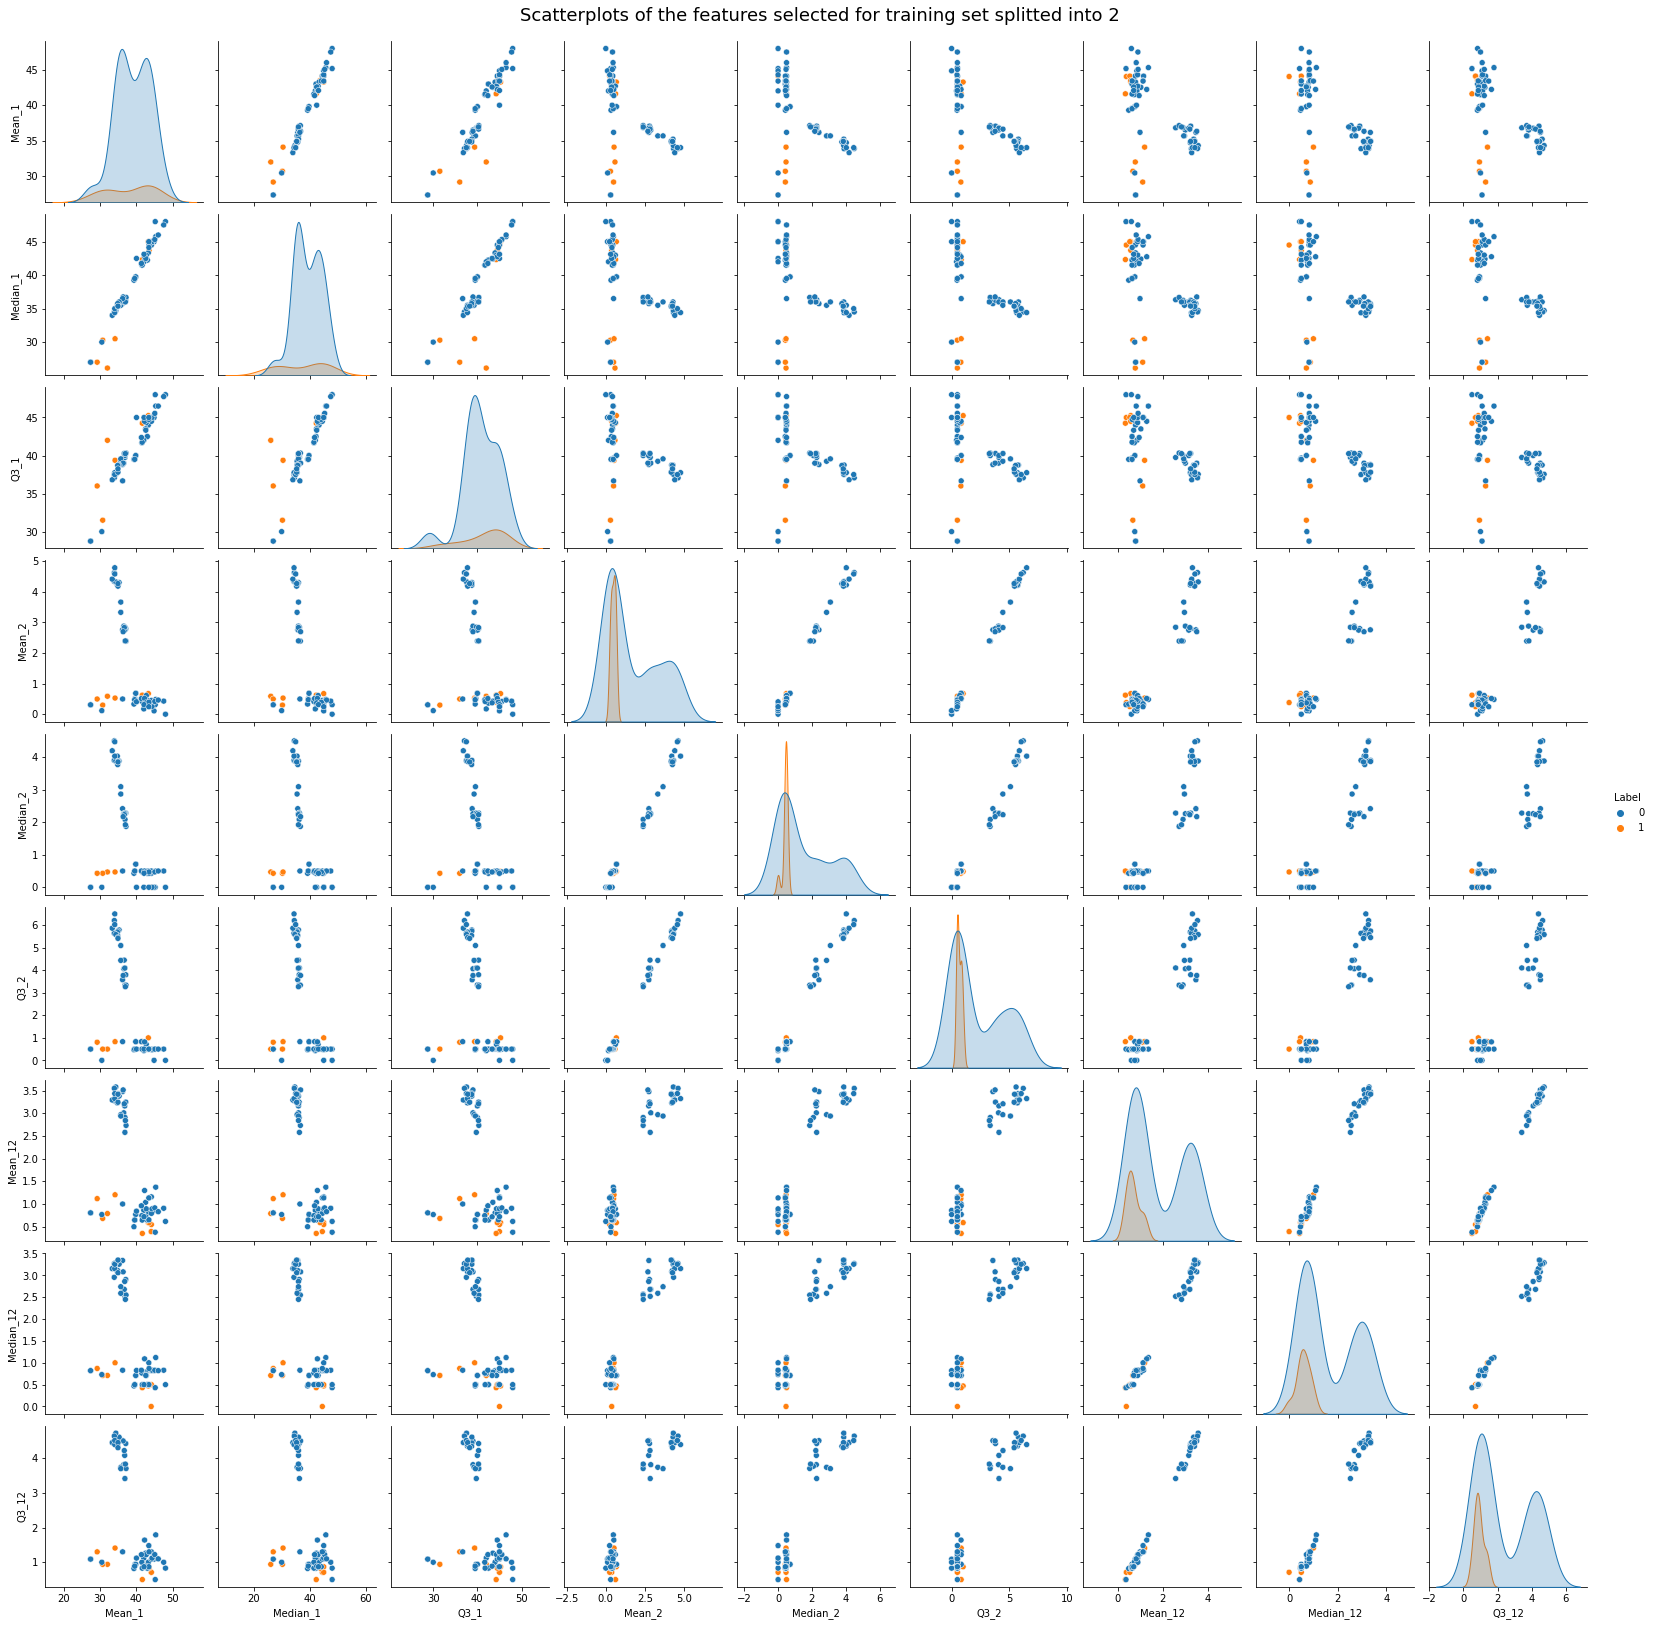

In [41]:
#Scatter plot 
plot = sns.pairplot(train_split_into_2[['Mean_1','Median_1','Q3_1','Mean_2','Median_2','Q3_2','Mean_12','Median_12','Q3_12','Label']],hue='Label')
plot.fig.suptitle("Scatterplots of the features selected for training set splitted into 2", y=1.008, fontsize = 18)


__Now, we take into consideration the following:
Segmenting Time Series Data:__

Initially, each time series in the training set is segmented into l ∈ {1, 2, ..., 20} parts of approximately equal length. This segmentation increases the dimensionality of our feature space, transforming each segment into a separate feature set while maintaining the original number of instances.
Applying Logistic Regression:

For each segmentation, I employ logistic regression to address the binary classification problem. This method is chosen for its effectiveness in handling binary data and its interpretability.
After training the model on each segment, I calculate the p-values of the logistic regression parameters. This statistical analysis is critical for understanding the significance of each feature in the model.
Feature Selection and Optimization:

Based on the p-values, I engage in feature pruning to refine the model. An alternative approach I am utilizing is backward selection, implemented through sklearn.feature_selection in Python.
This process is essential for identifying the most impactful features, thereby enhancing the model's performance.
Cross-Validation Technique:

To determine the best combination of segment length (l) and the number of features (p), I am implementing 5-fold cross-validation. This method is integral in assessing the model's generalizability.
I am particularly cautious about the approach to cross-validation. The correct method involves performing feature selection within each fold of the cross-validation. This prevents information leakage and ensures a more accurate evaluation of the model's performance.
Addressing Class Imbalance:

__Given the potential issue of class imbalance, which can skew the training process, I am prepared to use stratified cross-validation. This technique will ensure that each fold is representative of the overall class distribution, thereby maintaining the validity of our evaluation.__

In [43]:
output = {'l':[],'no_of_features(p)':[],'f1_score':[], 'feat_selected': []}
features_support = {'l':[],"val":[]}
for i in range(1,21):
    output['l'].append(i)
    features_support['l'].append(i)
    train_split_l = splitontrain(i,0)
    A = train_split_l.drop(train_split_l.columns[-1],axis=1)
    y = train_split_l[train_split_l.columns[-1]]
    model = LogisticRegression(max_iter=1000)
    selector_1 = RFECV(estimator=model,step=1, cv=StratifiedKFold(5), scoring='accuracy')
    selector_1 = selector.fit(A, y)
    output['no_of_features(p)'].append(selector_1.n_features_)
    output['f1_score'].append(f1_score(y, selector_1.predict(A)))
    output['feat_selected'].append(A.columns[selector_1.support_])
    features_support['val'].append(selector_1.support_)
out_df = pd.DataFrame(output)
features_support_df = pd.DataFrame(features_support)
print(out_df)
    

     l  no_of_features(p)  f1_score  \
0    1                  6  0.947368   
1    2                  1  0.750000   
2    3                  7  1.000000   
3    4                  8  1.000000   
4    5                 11  1.000000   
5    6                  1  0.875000   
6    7                  6  1.000000   
7    8                  9  1.000000   
8    9                  3  1.000000   
9   10                 16  1.000000   
10  11                  1  0.941176   
11  12                 28  1.000000   
12  13                  1  0.875000   
13  14                  1  0.875000   
14  15                 29  1.000000   
15  16                 29  1.000000   
16  17                  1  0.941176   
17  18                 52  1.000000   
18  19                 17  1.000000   
19  20                  1  0.941176   

                                        feat_selected  
0   Index(['Q3_1', 'Q3_2', 'Median_3', 'Median_4',...  
1                   Index(['Mean_5'], dtype='object')  
2   Index(['

In [44]:
##check and change
best_l = output['l'][output['f1_score'].index(np.amax(output['f1_score']))]
best_features = features_support['val'][features_support['l'].index(best_l)]
columns = []
column_names = ['Mean','Median','Q3']
for i in range(1,(best_l)*6+1):
    for j in column_names:
        columns.append(j+"_"+str(i))
selected_feature=[]
for i,x in enumerate(best_features):
    if x:
        selected_feature.append(columns[i])
print("The best l,p pair is: (",best_l,",",np.amax(out['f1_score']),")")
print("The best selected features are:",selected_feature)

The best l,p pair is: ( 3 , 1.0 )
The best selected features are: ['Mean_3', 'Mean_5', 'Median_5', 'Q3_5', 'Q3_7', 'Q3_8', 'Mean_17']


__Reporting the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.__

In [19]:
split_data = splitontrain(best_l,0)
X_train = split_data.drop(split_data.columns[-1],axis=1)
y_train = split_data[split_data.columns[-1]]
X_train = X_train[selected_feature]

best_model = LogisticRegression(max_iter=1000,random_state=42)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train)
statModel = sm.Logit(y_train, X_train).fit_regularized()
print("Parameters of logsitic regression are:")
print(statModel.params)
print("p-values")
print(statModel.pvalues)
print(statModel.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0938623800067258e-10
            Iterations: 38
            Function evaluations: 43
            Gradient evaluations: 38
Parameters of logsitic regression
Mean_3      -2.612537
Mean_5       9.914873
Median_5    -1.554107
Q3_5         8.206717
Q3_7        -7.383053
Q3_8       -12.542894
Mean_17     -0.107348
dtype: float64
p-values
Mean_3      1.0
Mean_5      1.0
Median_5    1.0
Q3_5        1.0
Q3_7        1.0
Q3_8        1.0
Mean_17     1.0
dtype: float64
                           Logit Regression Results                           
Dep. Variable:                  Label   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 17 Oct 2022   Pseudo R-squ.:                   1.000
Time:                        02:35:49   Log-Likeliho

In [20]:
#Function for Plot curve
def plot_curve(y_test,y_pred):
    cnf_matrix= confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cnf_matrix.ravel()
    FPR, TPR,threshold = roc_curve(y_test, y_pred)
    area_under_the_curve = auc(FPR, TPR)
    txt = 'ROC - area : ' + str(area_under_the_curve)
    plt.figure(figsize=(8, 6))
    plt.plot(FPR, TPR, color='cyan', label=txt)
    plt.plot([0, 1], [0, 1], linestyle='dotted')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC & AUC Curve')
    plt.legend()
    plt.show()

Confusion Matrix:
[[60  0]
 [ 0  9]]


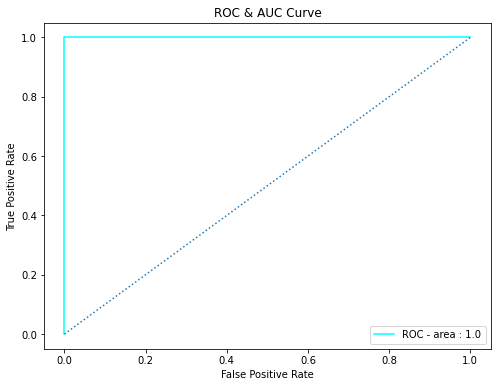

Accuracy score on Train data is  1.0


In [21]:

#Confusion matrix
from sklearn.metrics import roc_curve, auc
cnf_matrix= confusion_matrix(y_train, y_pred)
print("Confusion Matrix:")
print(cnf_matrix)
plot_curve(y_train, y_pred)
train_accuracy = metrics.accuracy_score(y_train, y_pred)
print("the accuracy score on Train data is ",train_accuracy)

__Testing the classifier on the test set__

Confusion Matrix
[[15  0]
 [ 0  4]]


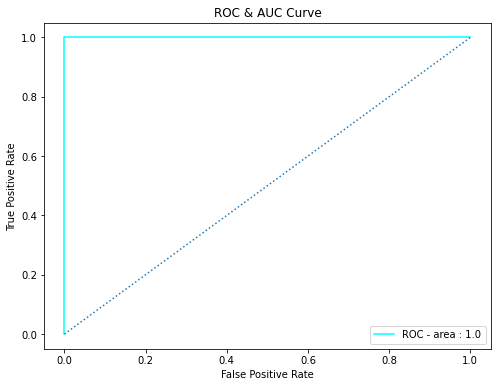

Accuracy score on the Test data is  1.0


In [45]:
X_train = split_data.drop(split_data.columns[-1],axis=1)
y_train = split_data[split_data.columns[-1]]
best_train_model = LogisticRegression()
best_train_model.fit(X_train, y_train)

test_set_5 = splitontest(best_l,0)
X_test = test_set_5.drop(test_set5.columns[-1],axis=1)
y_test = test_set_5[test_set_5.columns[-1]]

y_pred_test = best_train_model.predict(X_test)
cnf_matrix= confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix")
print(cnf_matrix)
plot_curve(y_test, y_pred_test)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test)
print("Accuracy score on the Test data is ",test_accuracy)


In [23]:
out = {'l':[],'no_of_features(p)':[],'f1_score':[], 'feat_selected': []}
feat_support = {'l':[],"val":[]}
for i in range(1,21):
    out['l'].append(i)
    feat_support['l'].append(i)
    train_split_l = splitontrain(i,0)
    X = train_split_l.drop(train_split_l.columns[-1],axis=1)
    y = train_split_l[train_split_l.columns[-1]]
    rand_sample = RandomUnderSampler(random_state=5)
    X_rand_sample, y_rand_sample = rand_sample.fit_resample(X, y)
    model_control_sample = LogisticRegression(max_iter=100)
    selector = RFECV(estimator=model,step=1, cv=StratifiedKFold(5), scoring='accuracy')
    selector.fit(X_rand_sample, y_rand_sample)
    out['no_of_features(p)'].append(selector.n_features_)
    out['f1_score'].append(f1_score(y_rand_sample, selector.predict(X_rand_sample)))
    out['feat_selected'].append(X_rand_sample.columns[selector.support_])
    feat_support['val'].append(selector.support_)
out_df = pd.DataFrame(out)
feat_support_df = pd.DataFrame(feat_support)
print(out_df)

     l  no_of_features(p)  f1_score  \
0    1                  2  0.888889   
1    2                  7  1.000000   
2    3                  5  1.000000   
3    4                  6  1.000000   
4    5                  6  1.000000   
5    6                 10  1.000000   
6    7                 10  1.000000   
7    8                  6  1.000000   
8    9                 11  1.000000   
9   10                 10  1.000000   
10  11                  9  1.000000   
11  12                  3  1.000000   
12  13                  7  1.000000   
13  14                 12  1.000000   
14  15                  9  1.000000   
15  16                  7  1.000000   
16  17                  9  1.000000   
17  18                 12  1.000000   
18  19                 10  1.000000   
19  20                  4  1.000000   

                                        feat_selected  
0           Index(['Mean_5', 'Q3_5'], dtype='object')  
1   Index(['Median_3', 'Mean_5', 'Median_5', 'Q3_5...  
2   Index(['

In [24]:
best_control_sample_l = out['l'][out['f1_score'].index(np.amax(out['f1_score']))]
best_features_control_sample = feat_support['val'][feat_support['l'].index(best_control_sample_l)]
columns = []
column_names = ['Mean','Median','Q3']
for i in range(1,(best_control_sample_l)*6+1):
    for j in column_names:
        columns.append(j+"_"+str(i))
control_sample_selected_feature=[]
for i,x in enumerate(best_features_control_sample):
    if x:
        control_sample_selected_feature.append(columns[i])
print("The best l,p pair is: (",best_control_sample_l,",",np.amax(out['f1_score']),")")
print("The best selected features are:",control_sample_selected_feature)
print(best_control_sample_l)

The best l,p pair is: ( 2 , 1.0 )
The best selected features are: ['Median_3', 'Mean_5', 'Median_5', 'Q3_5', 'Median_7', 'Q3_8', 'Mean_11']
2


Confusion Matrix
[[9 0]
 [0 9]]


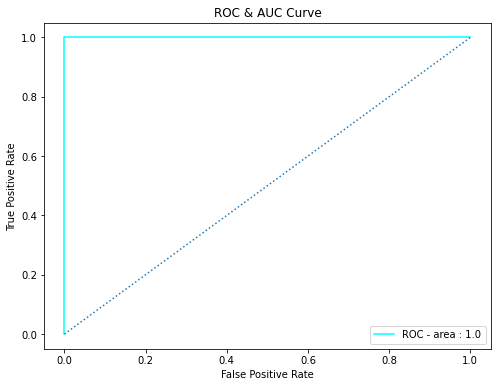

The accuracy score on Train data is  1.0


In [25]:
split_data_control_sample = splitontrain(best_control_sample_l,0)
X_train_control_sample = split_data_control_sample.drop(split_data_control_sample.columns[-1],axis=1)
y_train_control_sample = split_data_control_sample[split_data_control_sample.columns[-1]]

control_sample = RandomUnderSampler(random_state=5)
X_train_control_sample, y_train_control_sample = control_sample.fit_resample(X_train_control_sample, y_train_control_sample)

control_sample_model = LogisticRegression()
control_sample_model.fit(X_train_control_sample, y_train_control_sample)
y_pred_control_sample = control_sample_model.predict(X_train_control_sample)

cnf_matrix= confusion_matrix(y_train_control_sample, y_pred_control_sample)
print("Confusion Matrix")
print(cnf_matrix)
plot_curve(y_train_control_sample, y_pred_control_sample)
train_accuracy_control_sample = metrics.accuracy_score(y_train_control_sample, y_pred_control_sample)
print("The accuracy score on Train data is ",train_accuracy_control_sample)

Confusion Matrix
[[12  3]
 [ 0  4]]


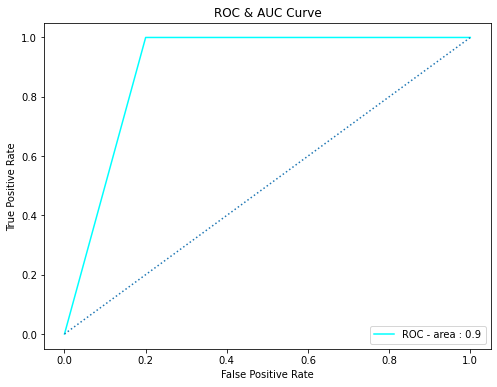

The accuracy score on Test data is  0.8421052631578947


In [26]:
split_data_control_sample_test = splitontest(best_control_sample_l,0)
X_test_control_sample = split_data_control_sample_test.drop(split_data_control_sample_test.columns[-1],axis=1)
y_test_control_sample = split_data_control_sample_test[split_data_control_sample_test.columns[-1]]

y_pred_test_control_sample = control_sample_model.predict(X_test_control_sample)

cnf_matrix= confusion_matrix(y_test_control_sample, y_pred_test_control_sample)
print("Confusion Matrix")
print(cnf_matrix)
plot_curve(y_test_control_sample, y_pred_test_control_sample)
test_accuracy = metrics.accuracy_score(y_test_control_sample, y_pred_test_control_sample)
print("The accuracy score on Test data is ",test_accuracy)

In [27]:
print(test_set['Foldername'])

0       bending1
1       bending1
2       bending1
3       bending1
4       bending1
          ...   
1435     walking
1436     walking
1437     walking
1438     walking
1439     walking
Name: Foldername, Length: 9120, dtype: object


__Binary Classification Using L1-penalized logistic regression__

In [28]:
L1_log_regr = {'l':[],'best_C':[],'max_scores':[]}
cs_ = []
for i in range(1,21):
    L1_log_regr['l'].append(i)
    train_split_by_l = splitontrain(i,0)
    X = train_split_by_l.drop(train_split_by_l.columns[-1],axis=1)
    y = train_split_by_l[train_split_by_l.columns[-1]]
    model = LogisticRegressionCV(cv=5, penalty="l1", solver="liblinear", random_state=5)
    model.fit(X, y)
    best_C = model.C_[0]
    L1_log_regr['best_C'].append(best_C)
    best_C_index = np.where(best_C==model.Cs_)[0][0]
    max_score = np.mean(model.scores_[1][:,best_C_index])
    L1_log_regr['max_scores'].append(max_score)
    
L1_log_regr_df = pd.DataFrame(L1_log_regr)
L1_log_regr_df

,l,best_C,max_scores
0,1,2.782559,0.956044
1,2,166.810054,0.957143
2,3,2.782559,0.971429
3,4,0.359381,0.957143
4,5,2.782559,0.971429
5,6,166.810054,0.971429
6,7,2.782559,0.957143
7,8,0.359381,0.957143
8,9,166.810054,0.957143
9,10,0.359381,0.957143


In [29]:
best_l_log_regr = L1_log_regr['l'][L1_log_regr['max_scores'].index(np.amax(L1_log_regr['max_scores']))]
best_C_log_regr = L1_log_regr['best_C'][L1_log_regr['max_scores'].index(np.amax(L1_log_regr['max_scores']))]
print("The best l,C pair obtained is: (",best_l_log_regr,",",best_C_log_regr,")")

The best l,C pair obtained is: ( 3 , 2.782559402207126 )


Confusion Matrix
[[60  0]
 [ 0  9]]


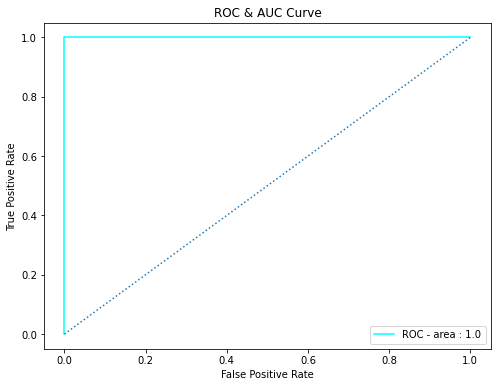

The accuracy score on Train data is  1.0


In [30]:
split_data_log_regr = splitontrain(best_l_log_regr,0)
X_train_log_regr = split_data_log_regr.drop(split_data_log_regr.columns[-1],axis=1)
y_train_log_regr = split_data_log_regr[split_data_log_regr.columns[-1]]

best_model_log_regr = LogisticRegression(penalty="l1", solver="liblinear",C=best_C_log_regr,random_state=42)
best_model_log_regr.fit(X_train_log_regr, y_train_log_regr)
y_pred_log_regr = best_model_log_regr.predict(X_train_log_regr)

cnf_matrix= confusion_matrix(y_train_log_regr, y_pred_log_regr)
print("Confusion Matrix")
print(cnf_matrix)

plot_curve(y_train_log_regr, y_pred_log_regr)

train_accuracy = metrics.accuracy_score(y_train_log_regr, y_pred_log_regr)
print("The accuracy score on Train data is ",train_accuracy)

Confusion Matrix
[[15  0]
 [ 0  4]]


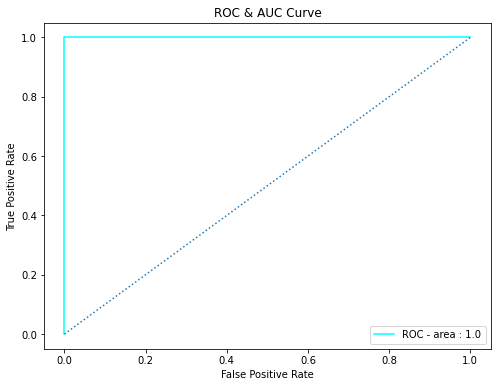

The accuracy score on Test data is  1.0


In [31]:
split_data_log_regr_test = splitontest(best_l_log_regr,0)
X_test_log_regr = split_data_log_regr_test.drop(split_data_log_regr_test.columns[-1],axis=1)
y_test_log_regr = split_data_log_regr_test[split_data_log_regr_test.columns[-1]]

y_pred_test_log_regr = best_model_log_regr.predict(X_test_log_regr)

cnf_matrix= confusion_matrix(y_test_log_regr, y_pred_test_log_regr)
print("Confusion Matrix")
print(cnf_matrix)

plot_curve(y_test_log_regr, y_pred_test_log_regr)

test_accuracy = metrics.accuracy_score(y_test_log_regr, y_pred_test_log_regr)
print("The accuracy score on Test data is ",test_accuracy)

As we can observe above, L1-penalized logistic regression and variable selection using p-values both seem to have training and testing accuracy score as 1. But L1-penalized is easier to implement and also has a better performance.

__Multi-class Classification (The Realistic Case)
building an L1- penalized multinomial regression model to classify all activities in THE training set.__

In [32]:
L1_log_regr_multi = {'l':[],'best_C':[],'max_scores':[]}
for i in range(1,21):
    L1_log_regr_multi['l'].append(i)
    split_train_by_l = splitontrain(i,1)
    X = split_train_by_l.drop(split_train_by_l.columns[-1],axis=1)
    y = split_train_by_l[split_train_by_l.columns[-1]]
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    model = LogisticRegressionCV(cv=5, penalty="l1", solver="saga",multi_class= 'multinomial')
    model.fit(X, y)
    best_C = model.C_[0]
    L1_log_regr_multi['best_C'].append(best_C)
    best_C_index = np.where(best_C==model.Cs_)[0][0]
    max_score = np.mean(model.scores_[0][:,best_C_index])
    L1_log_regr_multi['max_scores'].append(max_score)
    
L1_log_regr_multi_df = pd.DataFrame(L1_log_regr_multi)
L1_log_regr_multi_df

,l,best_C,max_scores
0,1,2.782559,0.882418
1,2,0.359381,0.839560
2,3,21.544347,0.869231
3,4,2.782559,0.867033
4,5,0.359381,0.797802
5,6,1291.549665,0.839560
6,7,166.810054,0.795604
7,8,166.810054,0.751648
8,9,0.359381,0.752747
9,10,10000.000000,0.765934


In [33]:
best_l_log_regr_multi = L1_log_regr_multi['l'][L1_log_regr_multi['max_scores'].index(np.amax(L1_log_regr_multi['max_scores']))]
best_C_log_regr_multi = L1_log_regr_multi['best_C'][L1_log_regr_multi['max_scores'].index(np.amax(L1_log_regr_multi['max_scores']))]
print("The best l,c pair obtained is: (",best_l_log_regr_multi,",",best_C_log_regr_multi,")")

The best l,c pair obtained is: ( 1 , 2.782559402207126 )


In [60]:
split_data_log_regr_multinomial = splitontrain(best_l_log_regr_multi,1)
X_train_log_regr_multinomial = split_data_log_regr_multinomial.drop(split_data_log_regr_multi.columns[-1],axis=1)
y_train_log_regr_multinomial = split_data_log_regr_multinomial[split_data_log_regr_multi.columns[-1]]
le = preprocessing.LabelEncoder()
y_train_log_regr_multinomial = le.fit_transform(y_train_log_regr_multinomial)

best_model_log_regr_multinomial = LogisticRegression(penalty="l1", solver="saga",multi_class= 'multinomial', C=best_C_log_regr_multi)
best_model_log_regr_multinomial.fit(X_train_log_regr_multi, y_train_log_regr_multi)

y_pred_log_regr_multinomial = best_model_log_regr_multinomial.predict(X_train_log_regr_multi)
y_pred_log_regr_multinomial = le.fit_transform(y_pred_log_regr_multinomial)

clf_p = OneVsRestClassifier(LogisticRegression(C=best_C_log_regr_multi,penalty='l1', multi_class='multinomial',solver='saga'))
predict_prob = clf_p.fit(X_train_log_regr_multinomial, y_train_log_regr_multinomial).decision_function(X_train_log_regr_multinomial)

cnf_matrix= confusion_matrix(y_train_log_regr_multinomial, y_pred_log_regr_multinomial)
print("Confusion Matrix")
print(cnf_matrix)
    


Confusion Matrix
[[ 8  0  0  1  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 1  0  1  9  1  0]
 [ 0  0  0  2 10  0]
 [ 0  0  0  0  0 12]]


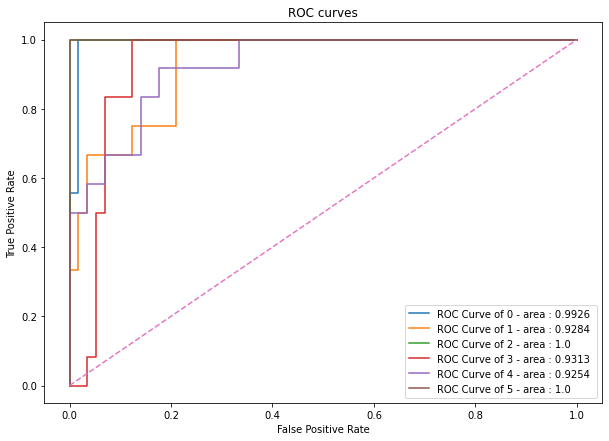

The accuracy score for train is  0.9130434782608695


In [59]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(best_model_log_regr_multi.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_train_log_regr_multinomial, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

train_accuracy = metrics.accuracy_score(y_train_log_regr_multinomial, y_pred_log_regr_multinomial)
print("The accuracy score for train is ",train_accuracy)

In [67]:
split_data_log_regr_multi_test = splitontest(best_l_log_regr_multi,1)
X_test_log_regr_multi = split_data_log_regr_multi_test.drop(split_data_log_regr_multi_test.columns[-1],axis=1)
y_test_log_regr_multi = split_data_log_regr_multi_test[split_data_log_regr_multi_test.columns[-1]]
le = preprocessing.LabelEncoder()
y_test_log_regr_multi = le.fit_transform(y_test_log_regr_multi)

y_pred_log_regr_multi_test = best_model_log_regr_multi.predict(X_test_log_regr_multi)
y_pred_log_regr_multi_test = le.fit_transform(y_pred_log_regr_multi_test)

predict_prob = clf_p.fit(X_train_log_regr_multi, y_train_log_regr_multi).decision_function(X_test_log_regr_multi)

cnf_matrix= confusion_matrix(y_test_log_regr_multi, y_pred_log_regr_multi_test)
print("Confusion Matrix")
print(cnf_matrix)
    

Confusion Matrix
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


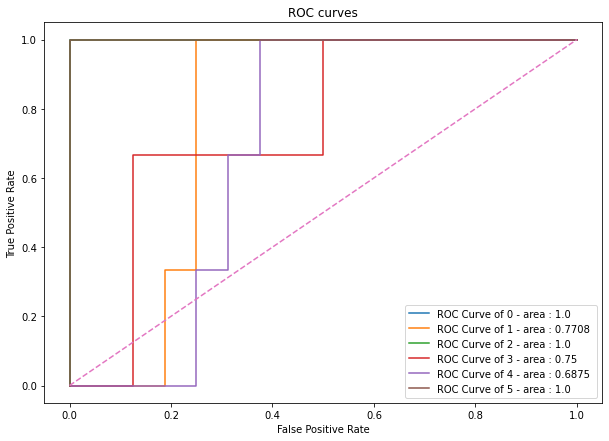

The accuracy score for test is  0.8947368421052632


In [66]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(best_model_log_regr_multi.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_test_log_regr_multi, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

train_accuracy = metrics.accuracy_score(y_test_log_regr_multi, y_pred_log_regr_multi_test)
print("The accuracy score for test is ",train_accuracy)

__using a Naıve Bayes’ classifier. Using both Gaussian and Multinomial priors and comparing the results.__

In [36]:
#Gaussian
L1_log_regr_gau = {'l':[],'scores':[]}

for i in range(1,21):
    L1_log_regr_gau['l'].append(i)
    split_train_by_l = splitontrain(i,1)
    X = split_train_by_l.drop(split_train_by_l.columns[-1],axis=1)
    y = split_train_by_l[split_train_by_l.columns[-1]]
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    gaussianClassifier = GaussianNB()
    gaussianClassifier.fit(X, y)
    score = cross_val_score(gaussianClassifier, X, y, cv=5)
    L1_log_regr_gau['scores'].append(np.mean(score))
    
L1_log_regr_gau_df = pd.DataFrame(L1_log_regr_gau)
print(L1_log_regr_gau_df)

best_l_gau = L1_log_regr_gau['l'][L1_log_regr_gau['scores'].index(np.amax(L1_log_regr_gau['scores']))]
print("The best l is for Gaussian is ",best_l_gau)

     l    scores
0    1  0.768132
1    2  0.783516
2    3  0.753846
3    4  0.782418
4    5  0.782418
5    6  0.739560
6    7  0.782418
7    8  0.769231
8    9  0.797802
9   10  0.783516
10  11  0.783516
11  12  0.769231
12  13  0.782418
13  14  0.724176
14  15  0.709890
15  16  0.682418
16  17  0.712088
17  18  0.696703
18  19  0.740659
19  20  0.712088
The best l is for Gaussian is  9


In [71]:
split_data_gau = splitontrain(best_l_gau,1)
X_train_gau = split_data_gau.drop(split_data_gau.columns[-1],axis=1)
y_train_gau = split_data_gau[split_data_gau.columns[-1]]

le = preprocessing.LabelEncoder()
y_train_gau = le.fit_transform(y_train_gau)

gaussian_model = GaussianNB()
gaussian_model.fit(X_train_gau, y_train_gau)

y_pred_gau = gaussian_model.predict(X_train_gau)
y_pred_gau = le.fit_transform(y_pred_gau)

clf_p = OneVsRestClassifier(GaussianNB())
predict_prob = clf_p.fit(X_train_gau, y_train_gau).predict_proba(X_train_gau)

cnf_matrix= confusion_matrix(y_train_gau, y_pred_gau)
print("Confusion Matrix")
print(cnf_matrix)
    


Confusion Matrix
[[ 8  0  1  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


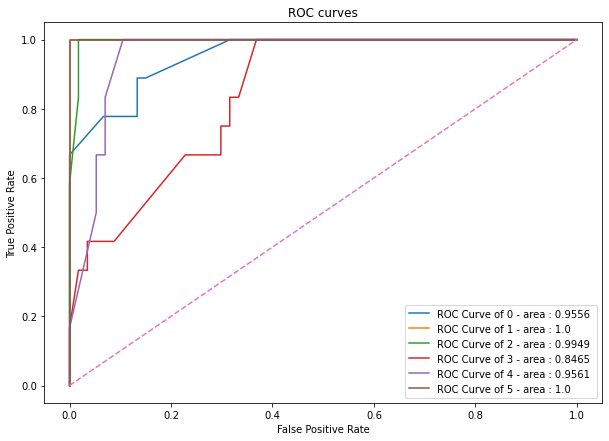

The accuracy score for Gaussian train is  0.9710144927536232


In [72]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(gaussian_model.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_train_gau, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

train_accuracy = metrics.accuracy_score(y_train_gau, y_pred_gau)
print("The accuracy score for Gaussian train is ",train_accuracy)

In [74]:
split_data_gau_test = splitontest(best_l_gau,1)
X_test_gau = split_data_gau_test.drop(split_data_gau_test.columns[-1],axis=1)
y_test_gau = split_data_gau_test[split_data_gau_test.columns[-1]]
le = preprocessing.LabelEncoder()
y_test_gau = le.fit_transform(y_test_gau)

y_pred_test_gau = gaussian_model.predict(X_test_gau)
y_pred_test_gau = le.fit_transform(y_pred_test_gau)

predict_prob = clf_p.fit(X_train_gau, y_train_gau).predict_proba(X_test_gau)

cnf_matrix= confusion_matrix(y_test_gau, y_pred_test_gau)
print("Confusion Matrix")
print(cnf_matrix)
    


Confusion Matrix
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


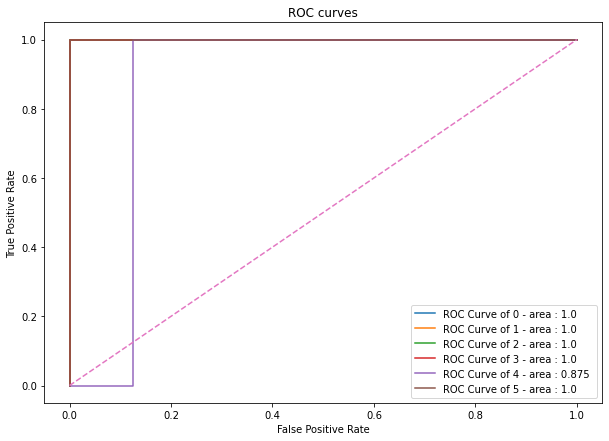

The accuracy score for Gaussian test is  0.8947368421052632


In [75]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(gaussian_model.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_test_gau, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

train_accuracy = metrics.accuracy_score(y_test_gau, y_pred_test_gau)
print("The accuracy score for Gaussian test is ",train_accuracy)

In [48]:
#Multinomial
L1_log_regr_multnomial = {'l':[],'scores':[]}

for i in range(1,21):
    L1_log_regr_multnomial['l'].append(i)
    split_train_by_l = splitontrain(i,1)
    X = split_train_by_l.drop(split_train_by_l.columns[-1],axis=1)
    y = split_train_by_l[split_train_by_l.columns[-1]]
    le = preprocessing.LabelEncoder()
    y = le.fit_transform(y)
    multinomial = MultinomialNB()
    multinomial.fit(X, y)
    L1_log_regr_multnomial['scores'].append(multinomial.score(X, y))
    
L1_log_regr_multnomial_df = pd.DataFrame(L1_log_regr_multnomial)
print(L1_log_regr_multnomial_df)

best_l_multnomial = L1_log_regr_multnomial['l'][L1_log_regr_multnomial['scores'].index(np.amax(L1_log_regr_multnomial['scores']))]
print("The best l is: ",best_l_multnomial)

     l    scores
0    1  0.898551
1    2  0.927536
2    3  0.942029
3    4  0.927536
4    5  0.942029
5    6  0.927536
6    7  0.942029
7    8  0.942029
8    9  0.942029
9   10  0.927536
10  11  0.927536
11  12  0.942029
12  13  0.942029
13  14  0.942029
14  15  0.942029
15  16  0.942029
16  17  0.942029
17  18  0.942029
18  19  0.942029
19  20  0.942029
The best l is:  3


In [77]:
split_data_multnomial = splitontrain(best_l_multnomial,1)
X_train_multnomial = split_data_multnomial.drop(split_data_multnomial.columns[-1],axis=1)
y_train_multnomial = split_data_multnomial[split_data_multnomial.columns[-1]]
le = preprocessing.LabelEncoder()
y_train_multnomial = le.fit_transform(y_train_multnomial)

multinomial_model = MultinomialNB()
multinomial_model.fit(X_train_multnomial, y_train_multnomial)
y_pred_multnomial = multinomial_model.predict(X_train_multnomial)
y_pred_multnomial = le.fit_transform(y_pred_multnomial)


clf_p = OneVsRestClassifier(MultinomialNB())
predict_prob = clf_p.fit(X_train_multnomial, y_train_multnomial).predict_proba(X_train_multnomial)

cnf_matrix= confusion_matrix(y_train_multnomial, y_pred_multnomial)
print("Confusion Matrix")
print(cnf_matrix)
    


Confusion Matrix
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 1  0  1  9  1  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


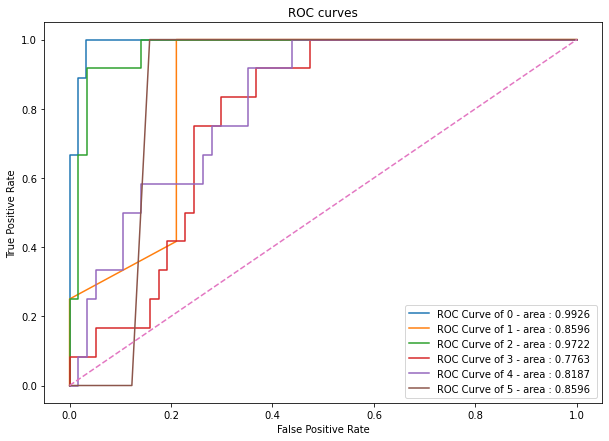

The accuracy score for Multinomial train is  0.9420289855072463


In [78]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(multinomial_model.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_train_multnomial, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

train_accuracy = metrics.accuracy_score(y_train_multnomial, y_pred_multnomial)
print("The accuracy score for Multinomial train is ",train_accuracy)

In [79]:
split_data_multnomial_testing = splitontest(best_l_multnomial,1)
X_test_multnomial = split_data_multnomial_testing.drop(split_data_multnomial_testing.columns[-1],axis=1)
y_test_multnomial = split_data_multnomial_testing[split_data_multnomial_testing.columns[-1]]

le = preprocessing.LabelEncoder()
y_test_multnomial = le.fit_transform(y_test_multnomial)

y_pred_test_multnomial = multinomial_model.predict(X_test_multnomial)
y_pred_test_multnomial = le.fit_transform(y_pred_test_multnomial)

predict_prob = clf_p.fit(X_train_multnomial, y_train_multnomial).predict_proba(X_test_multnomial)

cnf_matrix= confusion_matrix(y_test_multnomial, y_pred_test_multnomial)
print("Confusion Matrix")
print(cnf_matrix)
    


Confusion Matrix
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


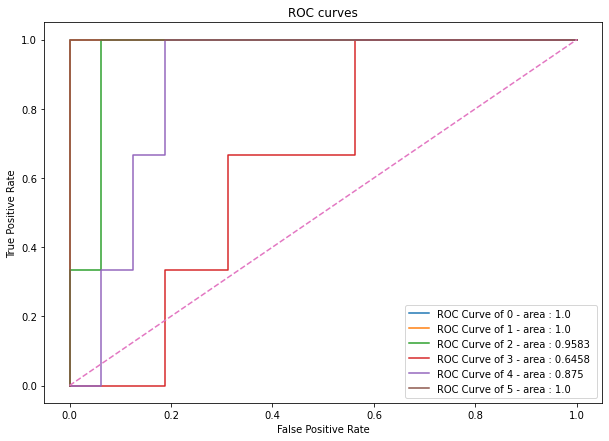

The accuracy score for Multinomial test is  0.8947368421052632


In [80]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fig, axes = plt.subplots(figsize=(10, 7))
for i, c in enumerate(multinomial_model.classes_):
    fpr[i], tpr[i], threshold = roc_curve(y_test_multnomial, predict_prob[:, i],pos_label=c)
    roc_auc[i] = auc(fpr[i], tpr[i])
    axes.plot(fpr[i], tpr[i], label="ROC Curve of {} - area : {} ".format(c, round(roc_auc[i], 4)))
axes.plot([0, 1], [0, 1], "--")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.set_title("ROC curves")
axes.legend()
plt.show()

train_accuracy = metrics.accuracy_score(y_test_multnomial, y_pred_test_multnomial)
print("The accuracy score for Multinomial test is ",train_accuracy)

__Though all the 3 methods have the same test accuracy score, Multinomial is better than the gaussian since the average score obtained from multinomial and Naive Bayes is higher than the scores obtained from Gaussian's Naive Bayes. Also as per the definition, multinomial naive bayes perfoms better for features that depend on the frequency and gaussian is preferred when the features are continuous.__

In [82]:
!pip freeze > ../requirements.txt